In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
from itertools import combinations
from scipy.stats import gumbel_r
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, StandardScaler

clf = load_model('clf.h5')


data = pd.read_csv('adult.csv')
data.drop(['fnlwgt', 'workclass', 'occupation', 'native-country'], axis = 1, inplace = True)

le = LabelEncoder()
data['education'], data['marital-status'], data['relationship'], data['race'], data['gender'], data['income'] = le.fit_transform(data['education']), le.fit_transform(data['marital-status']), le.fit_transform(data['relationship']), le.fit_transform(data['race']), le.fit_transform(data['gender']), le.fit_transform(data['income'])

to_remove = data[data['income'] == 0].sample(n=25468, random_state=42)
data = data.drop(to_remove.index)

X_train, X_test, y_train, y_test = train_test_split(data.loc[:,:'hours-per-week'].values, data.loc[:,'income'].values, test_size=0.1, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Evaluate classifier
y_train_pred = np.argmax(clf.predict(X_train), axis=1)
y_test_pred = np.argmax(clf.predict(X_test), axis=1)
print("Train accuracy:", accuracy_score(np.argmax(y_train, axis=1), y_train_pred))
print("Test accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

# Freeze classifier
for layer in clf.layers:
    layer.trainable = False

import tensorflow as tf
from tensorflow import keras
import numpy as np
from itertools import combinations
from sklearn.metrics import accuracy_score

# Standardize continuous features
continuous_indices = [0, 2, 7, 8, 9]  # age, education-num, capital-gain, capital-loss, hours-per-week
categorical_indices = [1, 3, 4, 5, 6]  # education, marital-status, relationship, race, gender

# Ensure X_train and X_test are float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Check for nan or inf in data
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    raise ValueError("X_train contains nan or inf values")
if np.any(np.isnan(X_test)) or np.any(np.isinf(X_test)):
    raise ValueError("X_test contains nan or inf values")

# Define cardinalities (hard-coded for Adult dataset)
cardinalities = {
    1: 16,  # education
    3: 7,   # marital-status
    4: 6,   # relationship
    5: 5,   # race
    6: 2    # gender
}

# Compute feature weights for continuous features (inverse std, post-scaling)
feature_std = np.std(X_train[:, continuous_indices], axis=0)
feature_weights = np.ones(10, dtype=np.float32)
feature_weights[continuous_indices] = 1.0 / (feature_std + 1e-10)
feature_weights[categorical_indices] = 1.0

# Evaluate classifier
y_train_pred = np.argmax(clf.predict(X_train), axis=1)
y_test_pred = np.argmax(clf.predict(X_test), axis=1)
print("Train accuracy:", accuracy_score(np.argmax(y_train, axis=1), y_train_pred))
print("Test accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

# Function to estimate mutual information for continuous feature pairs
def estimate_mi(x, y, bins=50):
    hist_2d, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    p_xy = hist_2d / np.sum(hist_2d + 1e-5) + 1e-5
    p_x = np.sum(p_xy, axis=1)
    p_y = np.sum(p_xy, axis=0)
    p_x_p_y = np.outer(p_x, p_y) + 1e-5
    valid = (p_xy > 1e-5) & (p_x_p_y > 1e-5)
    mi = np.sum(p_xy[valid] * np.log(p_xy[valid] / p_x_p_y[valid]))
    return np.clip(mi, 0, 5)

# Precompute MI for continuous feature pairs
n_features = X_train.shape[1]
mi_original = {}
feature_ranges = {}
for i, j in combinations(continuous_indices, 2):
    mi = estimate_mi(X_train[:, i], X_train[:, j], bins=50)
    mi_original[(i, j)] = mi
    feature_ranges[(i, j)] = (
        min(X_train[:, i].min(), X_train[:, j].min()),
        max(X_train[:, i].max(), X_train[:, j].max())
    )

mi_original_tf = {k: tf.constant(v, dtype=tf.float32) for k, v in mi_original.items()}

# Hyperparameters
latent_dim = 20
lambda_classification = 200.0
lambda_mi = 6
lambda_mse = 4
lambda_fixed = 0.5
lambda_kl = 0.00001 #0.0000001
n_fixed = 2
bins = 50

# Custom MI Loss Layer
class MILossLayer(keras.layers.Layer):
    def __init__(self, continuous_indices, feature_ranges, mi_original_tf, bins=50, lambda_mi=0.1, **kwargs):
        super(MILossLayer, self).__init__(**kwargs)
        self.continuous_indices = continuous_indices
        self.feature_ranges = feature_ranges
        self.mi_original_tf = mi_original_tf
        self.bins = bins
        self.lambda_mi = lambda_mi

    def call(self, inputs):
        x_recon = inputs
        mi_loss = 0.0
        for i, j in combinations(self.continuous_indices, 2):
            x_i = x_recon[:, i]
            x_j = x_recon[:, j]
            vmin, vmax = self.feature_ranges[(i, j)]
            vmin = tf.constant(vmin, dtype=tf.float32)
            vmax = tf.constant(vmax, dtype=tf.float32)
            bin_edges = tf.linspace(vmin, vmax, self.bins + 1)
            x_i_bin = tf.searchsorted(bin_edges, x_i, side='right') - 1
            x_j_bin = tf.searchsorted(bin_edges, x_j, side='right') - 1
            x_i_bin = tf.clip_by_value(x_i_bin, 0, self.bins - 1)
            x_j_bin = tf.clip_by_value(x_j_bin, 0, self.bins - 1)
            flat_indices = x_i_bin * bins + x_j_bin
            flat_indices = tf.cast(flat_indices, tf.int32)
            hist_1d = tf.math.bincount(flat_indices, minlength=bins * bins)
            hist_2d = tf.reshape(hist_1d, (bins, bins))
            hist_2d = tf.cast(hist_2d, tf.float32) + 1e-5
            p_xy = hist_2d / (tf.reduce_sum(hist_2d) + 1e-5)
            p_x = tf.reduce_sum(p_xy, axis=1) + 1e-5
            p_y = tf.reduce_sum(p_xy, axis=0) + 1e-5
            p_x_p_y = tf.expand_dims(p_x, 1) * tf.expand_dims(p_y, 0)
            valid = (p_xy > 1e-5) & (p_x_p_y > 1e-5)
            mi = tf.reduce_sum(tf.where(valid, p_xy * tf.math.log(p_xy / p_x_p_y), 0.0))
            mi_loss += tf.abs(tf.clip_by_value(mi - self.mi_original_tf[(i, j)], -5, 5))
        mi_loss = mi_loss / (len(self.mi_original_tf) + 1e-10)
        self.add_loss(self.lambda_mi * mi_loss)
        return x_recon

    def get_config(self):
        config = super(MILossLayer, self).get_config()
        config.update({
            'continuous_indices': self.continuous_indices,
            'feature_ranges': self.feature_ranges,
            'mi_original_tf': {k: v.numpy() for k, v in self.mi_original_tf.items()},
            'bins': self.bins,
            'lambda_mi': self.lambda_mi
        })
        return config

# Custom VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, clf, continuous_indices, categorical_indices, feature_weights, lambda_classification, lambda_kl, lambda_mse, lambda_fixed, lambda_mi, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.clf = clf
        self.continuous_indices = continuous_indices
        self.categorical_indices = categorical_indices
        self.feature_weights = tf.constant(feature_weights, dtype=tf.float32)
        self.lambda_classification = lambda_classification
        self.lambda_kl = lambda_kl
        self.lambda_mse = lambda_mse
        self.lambda_fixed = lambda_fixed
        self.lambda_mi = lambda_mi
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.classification_loss_tracker = keras.metrics.Mean(name="classification_loss")
        self.mi_loss_tracker = keras.metrics.Mean(name="mi_loss")

    def call(self, inputs, training=False):
        vae_inputs, t_inputs, mask_inputs = inputs
        mu, log_var = self.encoder(vae_inputs)
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(mu)[0], latent_dim))
        z = mu + tf.exp(0.5 * tf.clip_by_value(log_var, -10, 10)) * epsilon
        decoder_outputs = self.decoder([z, t_inputs, mask_inputs, vae_inputs])
        x_recon = decoder_outputs[0]
        CF = decoder_outputs[1]
        logits_list = decoder_outputs[2:]
        return x_recon, CF, logits_list, mu, log_var

    def train_step(self, data):
        (vae_inputs, t_inputs, mask_inputs), y_true = data
        with tf.GradientTape() as tape:
            x_recon, CF, logits_list, mu, log_var = self([vae_inputs, t_inputs, mask_inputs], training=True)

            # Fixed Feature Reconstruction Loss
            batch_size = tf.shape(mask_inputs)[0]
            fixed_recon_loss_continuous = tf.zeros([], dtype=tf.float32)
            fixed_recon_loss_categorical = tf.zeros([], dtype=tf.float32)

            # Continuous features
            continuous_mask = tf.zeros_like(mask_inputs, dtype=tf.float32)
            for idx in self.continuous_indices:
                indices = tf.stack([
                    tf.range(batch_size),
                    tf.fill([batch_size], tf.cast(idx, tf.int32))
                ], axis=1)
                continuous_mask = tf.tensor_scatter_nd_update(
                    continuous_mask,
                    indices,
                    tf.ones([batch_size], dtype=tf.float32)
                )
            continuous_mask = continuous_mask * mask_inputs
            fixed_recon_loss_continuous = tf.reduce_mean(
                tf.reduce_sum(continuous_mask * tf.square(vae_inputs - x_recon), axis=1)
            )

            # Categorical features
            categorical_mask = tf.zeros_like(mask_inputs, dtype=tf.float32)
            for idx in self.categorical_indices:
                indices = tf.stack([
                    tf.range(batch_size),
                    tf.fill([batch_size], tf.cast(idx, tf.int32))
                ], axis=1)
                categorical_mask = tf.tensor_scatter_nd_update(
                    categorical_mask,
                    indices,
                    tf.ones([batch_size], dtype=tf.float32)
                )
            categorical_mask = categorical_mask * mask_inputs
            categorical_errors = tf.zeros([batch_size], dtype=tf.float32)
            for idx, cat_idx in enumerate(self.categorical_indices):
                logits = logits_list[idx]
                true = tf.cast(vae_inputs[:, cat_idx], tf.int32)
                cat_loss = tf.keras.losses.sparse_categorical_crossentropy(true, logits)
                cat_mask = categorical_mask[:, cat_idx]
                categorical_errors += cat_mask * cat_loss
            fixed_recon_loss_categorical = tf.reduce_mean(categorical_errors)

            fixed_recon_loss = (fixed_recon_loss_continuous + fixed_recon_loss_categorical) / 10
            fixed_recon_loss = self.lambda_fixed * fixed_recon_loss

            # Mutable Feature Reconstruction Loss
            mutable_recon_loss_continuous = tf.zeros([], dtype=tf.float32)
            mutable_recon_loss_categorical = tf.zeros([], dtype=tf.float32)

            # Continuous features
            mutable_continuous_mask = tf.zeros_like(mask_inputs, dtype=tf.float32)
            for idx in self.continuous_indices:
                indices = tf.stack([
                    tf.range(batch_size),
                    tf.fill([batch_size], tf.cast(idx, tf.int32))
                ], axis=1)
                mutable_continuous_mask = tf.tensor_scatter_nd_update(
                    mutable_continuous_mask,
                    indices,
                    tf.ones([batch_size], dtype=tf.float32)
                )
            mutable_continuous_mask = mutable_continuous_mask * (1 - mask_inputs)
            mutable_recon_loss_continuous = tf.reduce_mean(
                tf.reduce_sum(mutable_continuous_mask * tf.square(vae_inputs - x_recon), axis=1)
            )

            # Categorical features
            mutable_categorical_mask = tf.zeros_like(mask_inputs, dtype=tf.float32)
            for idx in self.categorical_indices:
                indices = tf.stack([
                    tf.range(batch_size),
                    tf.fill([batch_size], tf.cast(idx, tf.int32))
                ], axis=1)
                mutable_categorical_mask = tf.tensor_scatter_nd_update(
                    mutable_categorical_mask,
                    indices,
                    tf.ones([batch_size], dtype=tf.float32)
                )
            mutable_categorical_mask = mutable_categorical_mask * (1 - mask_inputs)
            mutable_categorical_errors = tf.zeros([batch_size], dtype=tf.float32)
            for idx, cat_idx in enumerate(self.categorical_indices):
                logits = logits_list[idx]
                true = tf.cast(vae_inputs[:, cat_idx], tf.int32)
                cat_loss = tf.keras.losses.sparse_categorical_crossentropy(true, logits)
                cat_mask = mutable_categorical_mask[:, cat_idx]
                mutable_categorical_errors += cat_mask * cat_loss
            mutable_recon_loss_categorical = tf.reduce_mean(mutable_categorical_errors)

            mutable_recon_loss = (mutable_recon_loss_continuous + mutable_recon_loss_categorical) / 10
            mutable_recon_loss = self.lambda_mse * mutable_recon_loss

            # KL Divergence Loss
            kl_loss = tf.reduce_mean(tf.square(mu) + tf.exp(log_var) - log_var - 1.0)

            # Classification Loss (on CF)
            p = self.clf(CF)
            classification_loss = tf.keras.losses.sparse_categorical_crossentropy(tf.squeeze(t_inputs, axis=-1), p)

            # Total Loss (MI loss is added via MILossLayer)
            total_loss = mutable_recon_loss + self.lambda_kl * kl_loss + self.lambda_classification * classification_loss + fixed_recon_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(mutable_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        mi_loss = sum(self.losses) / self.lambda_mi if self.losses else 0.0
        self.mi_loss_tracker.update_state(mi_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "mi_loss": self.mi_loss_tracker.result(),
        }

# Encoder
encoder_inputs = keras.Input(shape=(10,), dtype=tf.float32, name='X')
x = keras.layers.Dense(64, activation='relu')(encoder_inputs)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
mu = keras.layers.Dense(latent_dim, name='mu')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
encoder = keras.Model(encoder_inputs, [mu, log_var], name='encoder')

# Decoder
z_inputs = keras.Input(shape=(latent_dim,), name='z')
t_inputs = keras.Input(shape=(1,), name='t')
mask_inputs = keras.Input(shape=(10,), name='mask')
vae_inputs = keras.Input(shape=(10,), dtype=tf.float32, name='X_input')
decoder_inputs = keras.layers.Concatenate(name='decoder_input')([z_inputs, t_inputs])
x = keras.layers.Dense(32, activation='relu')(decoder_inputs)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.BatchNormalization(momentum=0.9)(x)

outputs = []
logits_outputs = []
for i in range(10):
    if i in continuous_indices:
        # Apply Dense layer and enforce non-negativity with ReLU
        out = keras.layers.Dense(1, name=f'X{i}_recon')(x)
        out = tf.nn.relu(out)  # Ensure non-negative output
        outputs.append(out)
    else:
        # Categorical features are already non-negative (indices 0, 1, 2, ...)
        logits = keras.layers.Dense(cardinalities[i], name=f'X{i}_logits')(x)
        logits = tf.clip_by_value(logits, -10, 10)
        out = tf.cast(tf.argmax(logits, axis=-1), tf.float32, name=f'X{i}_recon')
        out = tf.expand_dims(out, axis=-1)
        outputs.append(out)
        logits_outputs.append(logits)

x_recon = keras.layers.Concatenate(name='X_recon')(outputs)
x_recon = MILossLayer(continuous_indices, feature_ranges, mi_original_tf, bins=bins, lambda_mi=lambda_mi)(x_recon)
CF = mask_inputs * vae_inputs + (1 - mask_inputs) * x_recon
decoder = keras.Model([z_inputs, t_inputs, mask_inputs, vae_inputs], [x_recon, CF] + logits_outputs, name='decoder')

# Instantiate VAE
vae = VAE(
    encoder=encoder,
    decoder=decoder,
    clf=clf,
    continuous_indices=continuous_indices,
    categorical_indices=categorical_indices,
    feature_weights=feature_weights,
    lambda_classification=lambda_classification,
    lambda_kl=lambda_kl,
    lambda_mse=lambda_mse,
    lambda_fixed=lambda_fixed,
    lambda_mi=lambda_mi
)

# Freeze classifier
for layer in clf.layers:
    layer.trainable = False

# Compile VAE with gradient clipping
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0))

# Prepare training data
t_train = (1 - np.argmax(clf.predict(X_train), axis=1)).reshape(-1, 1).astype(np.float32)

mask_train = np.zeros((X_train.shape[0], 10), dtype=np.float32)
indices_to_mask = [i for i in range(10) if i not in [5, 6]]
for i in range(X_train.shape[0]):
    fixed_indices = np.random.choice(indices_to_mask, size=n_fixed - 2, replace=False)
    mask_train[i, fixed_indices] = 1.0
    mask_train[i, 5] = 1.0  # race
    mask_train[i, 6] = 1.0  # gender

# Custom Callback to Monitor Preservation
class PreservationCallback(keras.callbacks.Callback):
    def __init__(self, X_val, t_val, mask_val, tolerance=1e-5):
        super().__init__()
        self.X_val = X_val
        self.t_val = t_val
        self.mask_val = mask_val
        self.tolerance = tolerance

    def on_epoch_end(self, epoch, logs=None):
        x_recon_val, CF_val, _, _, _ = self.model.predict([self.X_val, self.t_val, self.mask_val], verbose=0)
        diff_cf = np.abs(self.X_val - CF_val) * self.mask_val
        preserved_cf = np.all(diff_cf <= self.tolerance, axis=1)
        preservation_rate_cf = np.mean(preserved_cf)
        print(f"Epoch {epoch + 1}: CF Preservation Rate = {preservation_rate_cf:.4f}")

# Split validation data
val_split = 0.1
n_val = int(X_train.shape[0] * val_split)
X_val = X_train[-n_val:]
t_val = t_train[-n_val:]
mask_val = mask_train[-n_val:]
X_train = X_train[:-n_val]
t_train = t_train[:-n_val]
mask_train = mask_train[:-n_val]

# Train VAE
vae.fit(
    [X_train, t_train, mask_train],
    X_train,
    epochs=80,
    batch_size=16,
    validation_data=([X_val, t_val, mask_val], None),
    callbacks=[PreservationCallback(X_val, t_val, mask_val)],
    verbose=1
)

74/74 [==============================] - 0s 490us/step
Train accuracy: 0.8281042023198326
Test accuracy: 0.8284858853721129
74/74 [==============================] - 0s 486us/step
Train accuracy: 0.8281042023198326
Test accuracy: 0.8284858853721129
658/658 [==============================] - 0s 459us/step
Epoch 1/80
1184/1184 [==============================] - 11s 5ms/step - loss: 49278156.1325 - reconstruction_loss: 47594864.0000 - kl_loss: 9.9555 - classification_loss: 76.7260 - mi_loss: 0.3622 - val_loss: 1.8054 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_classification_loss: 0.0000e+00 - val_mi_loss: 0.0000e+00
Epoch 2/80
1184/1184 [==============================] - 3s 3ms/step - loss: 46527332.0000 - reconstruction_loss: 46954944.0000 - kl_loss: 20.2053 - classification_loss: 3.9749 - mi_loss: 0.3475 - val_loss: 2.1660 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_classificati

74/74 [==============================] - 0s 480us/step
Execution time: 0.0496 seconds
74/74 [==============================] - 0s 455us/step
Number of flips: 2262 out of 2338
Flip rate: 0.9675
Preservation Rate: 1.0000
Max Difference in Fixed Features: 0.000000
Mean Difference in Fixed Features: 0.000000


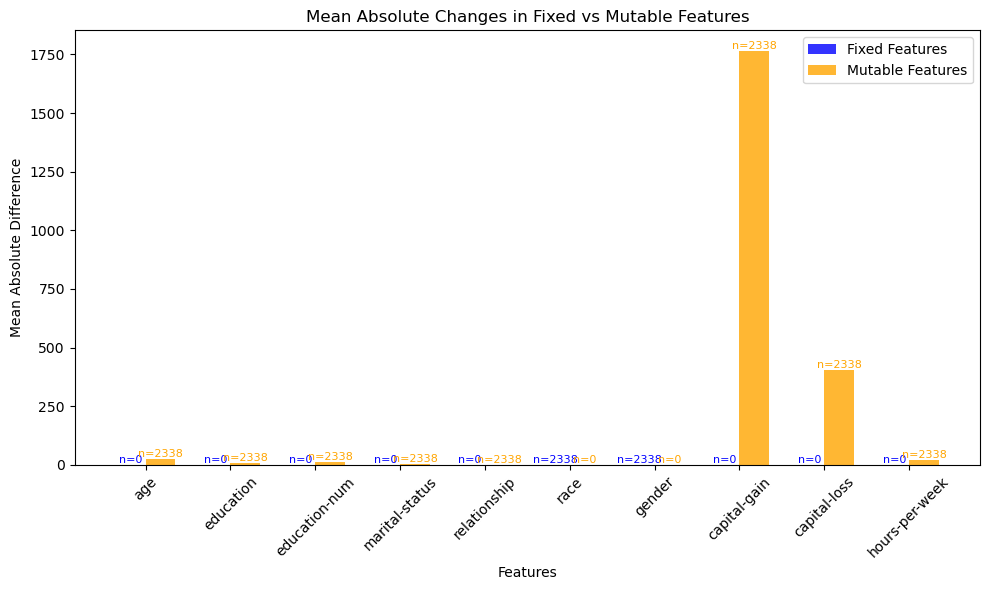

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Prepare test data
t_test = (1 - np.argmax(clf.predict(X_test), axis=1)).reshape(-1, 1).astype(np.float32)

# Generate masks for test set: fix ~4 features, race (5) and gender (6) always fixed
n_fixed = 2
mask_test = np.zeros((X_test.shape[0], 10), dtype=np.float32)
indices_to_mask = [i for i in range(10) if i not in [5, 6]]
for i in range(X_test.shape[0]):
    fixed_indices = np.random.choice(indices_to_mask, size=n_fixed - 2, replace=False)
    mask_test[i, fixed_indices] = 1.0
    mask_test[i, 5] = 1.0  # race
    mask_test[i, 6] = 1.0  # gender


import time
start_time = time.time()  # Record start time
outputs = vae.predict([X_test[:100], t_test[:100], mask_test[:100]], verbose=0)
end_time = time.time()  # Record end time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")


# Generate counterfactuals using the VAE
outputs = vae.predict([X_test, t_test, mask_test], verbose=0)

x_recon = outputs[0]  # Raw reconstruction
X_test_recon = outputs[1]  # Counterfactual (CF) output

# Get original and counterfactual predictions
y_test_pred_orig = np.argmax(clf.predict(X_test), axis=1)
y_test_pred_recon = np.argmax(clf.predict(X_test_recon), axis=1)

# Compute flip rate
flips = np.sum(y_test_pred_orig != y_test_pred_recon)
flip_rate = flips / len(y_test_pred_orig)

print(f"Number of flips: {flips} out of {len(y_test_pred_orig)}")
print(f"Flip rate: {flip_rate:.4f}")

# Verify preservation
tolerance = 1e-5
diff = np.abs(X_test - X_test_recon) * mask_test  # Differences where mask = 1
preserved_per_sample = np.all(diff <= tolerance, axis=1)
preservation_rate = np.mean(preserved_per_sample)
max_diff = np.max(diff)
mean_diff = np.sum(diff) / np.sum(mask_test) if np.sum(mask_test) > 0 else 0.0
print(f"Preservation Rate: {preservation_rate:.4f}")
print(f"Max Difference in Fixed Features: {max_diff:.6f}")
print(f"Mean Difference in Fixed Features: {mean_diff:.6f}")

# Function to plot mean absolute changes
def plot_feature_changes(X_original, X_cf, mask, feature_names=None, save_path='feature_changes.png'):
    """
    Generate a bar plot showing mean absolute changes in fixed and mutable features.
    """
    n_features = X_original.shape[1]
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(n_features)]
    
    # Compute absolute differences
    diff = np.abs(X_original - X_cf)
    
    # Initialize arrays to store mean differences and counts
    fixed_diff = np.zeros(n_features)
    mutable_diff = np.zeros(n_features)
    fixed_count = np.zeros(n_features)
    mutable_count = np.zeros(n_features)
    
    # Calculate mean differences for fixed and mutable features
    for i in range(n_features):
        fixed_mask = mask[:, i] == 1
        mutable_mask = mask[:, i] == 0
        fixed_count[i] = np.sum(fixed_mask)
        mutable_count[i] = np.sum(mutable_mask)
        if fixed_count[i] > 0:
            fixed_diff[i] = np.mean(diff[fixed_mask, i])
        if mutable_count[i] > 0:
            mutable_diff[i] = np.mean(diff[mutable_mask, i])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(n_features)
    
    plt.bar(index, fixed_diff, bar_width, label='Fixed Features', color='blue', alpha=0.8)
    plt.bar(index + bar_width, mutable_diff, bar_width, label='Mutable Features', color='orange', alpha=0.8)
    
    plt.xlabel('Features')
    plt.ylabel('Mean Absolute Difference')
    plt.title('Mean Absolute Changes in Fixed vs Mutable Features')
    plt.xticks(index + bar_width / 2, feature_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    
    # Add text annotations for counts
    for i in range(n_features):
        plt.text(i, fixed_diff[i], f'n={int(fixed_count[i])}', ha='center', va='bottom', color='blue', fontsize=8)
        plt.text(i + bar_width, mutable_diff[i], f'n={int(mutable_count[i])}', ha='center', va='bottom', color='orange', fontsize=8)

    plt.show()
    #plt.savefig(save_path)
    #plt.close()

# Define feature names based on Adult dataset
feature_names = ['age', 'education', 'education-num', 'marital-status', 'relationship', 
                 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week']

# Plot the changes
plot_feature_changes(X_test, X_test_recon, mask_test, feature_names)

In [10]:
counterfactuals = pd.DataFrame(X_test_recon, columns = feature_names)

### CES

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression


def estimate_linear_relationship(X):
    """
    Estimate linear relationship: hours-per-week ≈ a * age + b
    Returns a, b, std of residuals
    """
    age = X[:, 0].reshape(-1, 1)
    hours = X[:, 9]

    reg = LinearRegression()
    reg.fit(age, hours)

    pred = reg.predict(age)
    residuals = hours - pred
    std = np.std(residuals)

    return reg.coef_[0], reg.intercept_, std


# Estimate parameters using training data
a_est, b_est, std_est = estimate_linear_relationship(X_train)

def compute_log_likelihood_adult(value, mean, std):
    return norm.logpdf(value, loc=mean, scale=std)

def compute_all_log_likelihoods_adult(X):
    """
    Compute log-likelihood of linear dependency between age (col 0) and hours-per-week (col 9)
    """
    age = X[:, 0]
    hours = X[:, 9]

    pred_hours = a_est * age + b_est
    ll = compute_log_likelihood_adult(hours, pred_hours, std_est)
    return ll


def compute_causal_edge_score_adult(CF: pd.DataFrame, X_test: np.ndarray) -> float:
    CF_np = CF.to_numpy()
    # Ensure both arrays have shape (n_samples, 10)
    assert CF_np.shape[1] >= 10, "CF input must contain at least 10 features."

    ll_cf = compute_all_log_likelihoods_adult(CF_np)
    ll_x = compute_all_log_likelihoods_adult(X_test)
    return np.mean(ll_cf - ll_x)


CF = counterfactuals
X_test_subset = X_test[:len(CF)]

score = compute_causal_edge_score_adult(CF, X_test_subset)
print("Causal-Edge Score (Adult):", score)


Causal-Edge Score (Adult): -88.10560805696761


### DPS

In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

feature_names = [
    "age",             # 0
    "education",       # 1 (categorical)
    "education-num",   # 2
    "marital-status",  # 3 (categorical)
    "relationship",    # 4 (categorical)
    "race",            # 5 (categorical)
    "gender",          # 6 (categorical)
    "capital-gain",    # 7
    "capital-loss",    # 8
    "hours-per-week"   # 9
]

train_df = pd.DataFrame(X_train, columns=feature_names)




CF.columns = feature_names  # Ensure proper alignment
dependencies = {
    'hours-per-week': ['age']
}


models = {}
for target, parents in dependencies.items():
    X = train_df[parents]
    y = train_df[target]

    model = LinearRegression()
    model.fit(X, y)
    models[target] = model


errors = []
for target, parents in dependencies.items():
    X_cf = CF[parents]
    y_cf_true = CF[target]
    y_cf_pred = models[target].predict(X_cf)

    std = train_df[target].std()
    normalized_error = np.abs(y_cf_pred - y_cf_true) / std

    scores = np.exp(-normalized_error)  # Higher = better preservation
    errors.append(scores)


DPS_scores = np.mean(np.stack(errors, axis=1), axis=1)
DPS = np.mean(DPS_scores)

print(f"DPS Score (Adult Data): {DPS:.4f}")


DPS Score (Adult Data): 0.7902


### IM1

In [13]:
autoencoder_1 = load_model('AE1.h5')
autoencoder_0 = load_model('AE0.h5')

cf_samples = CF.values


original_labels = np.argmax(clf.predict(X_test), axis=1)
counterfactual_labels = np.argmax(clf.predict(cf_samples), axis=1)

74/74 [==============================] - 0s 495us/step


In [14]:
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

# Config
continuous_indices = [0, 2, 7, 8, 9]
categorical_indices = [1, 3, 4, 5, 6]
n_categories = {
    1: data['education'].nunique(),
    3: data['marital-status'].nunique(),
    4: data['relationship'].nunique(),
    5: data['race'].nunique(),
    6: data['gender'].nunique()
}

mse = MeanSquaredError()
cce = CategoricalCrossentropy()

def compute_reconstruction_loss(x, model):
    """
    Compute mixed (continuous + categorical) reconstruction loss for a single sample.
    """
    x = x.reshape(1, -1)
    preds = model.predict(x, verbose=0)

    loss_total = 0.0
    for i, output in enumerate(preds):
        if i in continuous_indices:
            # MSE between original and predicted continuous value
            loss = mse(x[:, i].reshape(-1, 1), output).numpy()
        elif i in categorical_indices:
            # Categorical crossentropy between one-hot and softmax output
            true_cat = to_categorical(x[:, i].astype(int), num_classes=n_categories[i])
            loss = cce(true_cat, output).numpy()
        else:
            raise ValueError(f"Unexpected index {i} in reconstruction")
        loss_total += loss

    return loss_total


reconstruction_ratios = []

for i in range(len(cf_samples)):
    x_cf = cf_samples[i]
    y_orig = original_labels[i]
    y_cf = counterfactual_labels[i]

    # Select appropriate AEs
    if y_orig == 0 and y_cf == 1:
        AE_o = autoencoder_0
        AE_t = autoencoder_1
    elif y_orig == 1 and y_cf == 0:
        AE_o = autoencoder_1
        AE_t = autoencoder_0
    else:
        continue

    # Compute reconstruction losses
    loss_t = compute_reconstruction_loss(x_cf, AE_t)
    loss_o = compute_reconstruction_loss(x_cf, AE_o)

    if loss_o > 0:
        reconstruction_ratios.append(loss_t / loss_o)

# Final IM1 Score
if reconstruction_ratios:
    im1_score = np.mean(reconstruction_ratios)
    print(f"IM1 Score: {im1_score:.4f}")
else:
    print("No valid counterfactuals to evaluate IM1.")


IM1 Score: 0.8832


### Distance

In [15]:
import numpy as np

def compute_mean_normalized_l2_distance(factuals, counterfactuals, feature_types, data):
    """
    Compute the mean L2-normalized distance between factual and counterfactual samples,
    normalizing each continuous feature by its (max - min) computed from the full data.

    Parameters:
    - factuals: np.ndarray of shape (n_samples, n_features)
    - counterfactuals: np.ndarray of same shape
    - feature_types: list of 'continuous' or 'categorical'
    - data: np.ndarray of shape (n_data_samples, n_features) used to estimate feature ranges

    Returns:
    - mean_normalized_distance: float
    """
    assert factuals.shape == counterfactuals.shape, "Shape mismatch between factuals and counterfactuals"
    assert factuals.shape[1] == len(feature_types), "Feature types length mismatch"
    assert data.shape[1] == factuals.shape[1], "Data and factuals must have same number of features"

    n_samples, n_features = factuals.shape

    # Compute feature ranges from the entire dataset
    feature_ranges = []
    for j in range(n_features):
        if feature_types[j] == 'continuous':
            max_val = np.max(data[:, j])
            min_val = np.min(data[:, j])
            range_val = max_val - min_val
            feature_ranges.append(range_val if range_val != 0 else 1e-8)  # avoid division by zero
        else:
            feature_ranges.append(1.0)  # categorical features are treated as 0/1

    distances = []

    for i in range(n_samples):
        dist_sq = 0
        for j in range(n_features):
            f, cf = factuals[i, j], counterfactuals[i, j]
            if feature_types[j] == 'continuous':
                norm_diff = (f - cf) / feature_ranges[j]
                dist_sq += norm_diff ** 2
            elif feature_types[j] == 'categorical':
                dist_sq += 0 if f == cf else 1  # Categorical mismatch adds 1
            else:
                raise ValueError(f"Unknown feature type: {feature_types[j]}")
        distances.append(np.sqrt(dist_sq))  # L2 distance for the sample

    return np.mean(distances)


In [17]:
# Compute distance
feature_types = ['continuous', 'categorical', 'continuous', 'categorical', 'categorical', 'categorical', 'categorical', 'continuous', 'continuous', 'continuous']
data = np.vstack([X_train, X_test])

mean_dist = compute_mean_normalized_l2_distance(X_test, cf_samples, feature_types, data)
print("Mean L2 Distance:", mean_dist)

Mean L2 Distance: 2.3088702012963154
